# SIFT ALGORITHM IMPLEMENTATION

## IMPORTS

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

## IMPLEMENTATION

- Constructing the Scale Space
  * Gaussian Blur
  * Difference of Gaussians
- Keypoint Localization
  * Local Maxima and Local Minima
  * Keypoint Selection
- Orientation Assignment
  * Calculate Magnitude and Orientation
  * Creating a Histogram for Magnitude and Orientation
- Keypoint Descriptor

### **1-Scale Space Construction**

- The image is transformed into a scale-space representation using a Gaussian pyramid.

- The Difference of Gaussian (DoG) is computed by subtracting successive Gaussian-blurred images.

- Local extrema (keypoints) are detected by comparing each pixel with its neighbors in the current and adjacent scales.

In [ ]:
def build_scale_space(image_path, num_octaves=4, scales_per_octave=3, base_sigma=1.6):
    image = cv2.imread(image_path)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(float) # convert image to gray scale
    scale_space = [] # list to store image at different scales and octaves

    #downsampling image
    for octave in range(num_octaves):
        octave_images = [] #octave images group at diff scale and blurr
        img = gray_img

        # octave = 0 use orig image
        # else down sample image by half each time
        if octave > 0:
            img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))

        #We generate scales_per_octave (default is 3) plus 3 extra images.
        for scale in range(scales_per_octave + 3):
            sigma = base_sigma * (2 ** (scale / scales_per_octave))
            blurred = gaussian_filter(img, sigma=sigma)
            octave_images.append(blurred)
        scale_space.append(octave_images)
    return scale_space

In [ ]:
scale_space = build_scale_space('./img1.jpg')

In [ ]:
len(scale_space)

4

### **2. Compute Difference of Gaussians (DoG)**

In [ ]:
def compute_dog(scale_space):
    dog_pyramid = [] #store the DoG images for all octaves.
    for octave in scale_space:
        dog_octave = [] # dog_octave will store the DoG images for one octave.
        for i in range(len(octave) - 1):
            diff = octave[i + 1] - octave[i] #Calculate DOG
            dog_octave.append(diff)
        dog_pyramid.append(dog_octave)
    return dog_pyramid

In [ ]:
dog_pyramid = compute_dog(scale_space)

### **3.Detect Keypoints (Extrema Detection)**

In [ ]:
def detect_keypoints(dog_pyramid, threshold=0.03):
    keypoints = [] #stores detected keypoints with their location, scale, and magnitude.
    for o, octave in enumerate(dog_pyramid):
        h, w = octave[0].shape
        for s in range(1, len(octave)-1): #exclude the first and last scales because extrema detection requires a 3D neighborhood
            prev, curr, next = octave[s-1:s+2]

            #Ignores the border pixels since a 3×3×3 neighborhood is needed for comparison.
            for i in range(1, h-1):
                for j in range(1, w-1):
                  #Extract the Pixel's 3D Neighborhood
                    pixel = curr[i, j]
                    region = np.concatenate([
                        prev[i-1:i+2, j-1:j+2].flatten(),
                        curr[i-1:i+2, j-1:j+2].flatten(),
                        next[i-1:i+2, j-1:j+2].flatten()
                    ])
                    region = np.delete(region, 13)  # Remove center pixel

                    #Check for Local Extrema
                    if (pixel > np.max(region) or pixel < np.min(region)) and abs(pixel) > threshold:
                        keypoints.append({
                            'octave': o,
                            'scale': s,
                            'x': j * (2 ** o),
                            'y': i * (2 ** o),
                            'magnitude': abs(pixel)
                        })
    return keypoints

In [ ]:
key_points = detect_keypoints(dog_pyramid)

### **4. Compute Keypoint Orientations**

In [ ]:
def compute_orientations(keypoints, scale_space):
    oriented_keypoints = [] #Stores keypoints with orientation and magnitude information.

    #Loops through all keypoints detected in the DoG pyramid.
    for kp in keypoints:
        o, s = kp['octave'], kp['scale']
        img = scale_space[o][s]
        h, w = img.shape
        x, y = int(kp['x']/(2**o)), int(kp['y']/(2**o))

        if x < 1 or y < 1 or x >= w-1 or y >= h-1:
            continue

        dx = img[y, x+1] - img[y, x-1]
        dy = img[y+1, x] - img[y-1, x]

        mag = np.sqrt(dx*dx + dy*dy)
        ori = np.arctan2(dy, dx)

        kp['orientation'] = ori
        kp['magnitude'] = mag
        oriented_keypoints.append(kp) #Stores the computed orientation and magnitude in the keypoint dictionary.

    return oriented_keypoints

In [ ]:
keypoints_orientation = compute_orientations(key_points, scale_space)

### **Visualization**

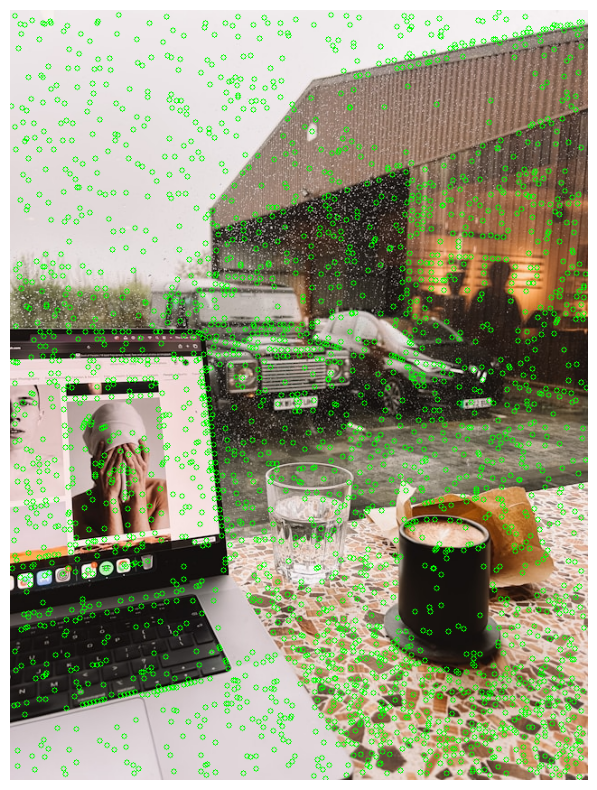

Found 3458 keypoints


In [ ]:
img = cv2.imread('img1.jpg')
img_with_keypoints = img.copy()
for kp in keypoints_orientation:
    x, y = int(kp['x']), int(kp['y'])
    cv2.circle(img_with_keypoints, (x, y), 3, (0, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(f"Found {len(keypoints_orientation)} keypoints")